In [10]:
# Package import
import json
import pandas as pd
import networkx as nx
from networkx.algorithms import community
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Data reading
f = open(r'../congress_network/congress_network_data.json')
data = json.load(f)

# Edges
inList = data[0]['inList']
inWeight = data[0]['inWeight']
outList = data[0]['outList']
outWeight = data[0]['outWeight']
usernameList = data[0]['usernameList']

# Attributes
attributes_df = pd.read_csv('../congress_network/congress_member_attributes.csv')
def recode_age(age) :
    if age<40 :
        return "Moins de 40 ans"
    elif age<50:
        return "40 à 49 ans"
    elif age<60:
        return "50 à 59 ans"
    elif age<70:
        return "60 à 69 ans"
    elif age<80:
        return "70 à 79 ans"
    else:
        return "Plus de 80 ans"
attributes_df["age_recode"] = attributes_df["age"].apply(recode_age)
attributes_df["sex"] = attributes_df["sex"].replace({"H":"M"})

attributes_df.head()

,congress_member,sex,age,party,chamber,age_recode
0,SenatorBaldwin,F,60,D,S,60 à 69 ans
1,SenJohnBarrasso,M,70,R,S,70 à 79 ans
2,SenatorBennet,M,60,D,S,60 à 69 ans
3,MarshaBlackburn,F,70,R,S,70 à 79 ans
4,SenBlumenthal,M,76,D,S,70 à 79 ans


### Description of attribute categories

In [14]:
# Selecting the data
df = attributes_df.sort_values("age").drop(["congress_member","age"],axis=1).copy()

# Dictionnary for the results
results = {}

# Compute count values for each attribute
for column in df.columns:
    value_counts = df[column].value_counts()
    results[column] = value_counts

multi_header_df = pd.DataFrame()

for column, value_counts in results.items():
    multi_index = pd.MultiIndex.from_product([[column], value_counts.index], names=['Category', 'Valeurs'])
    multi_header_df = pd.concat([multi_header_df, pd.DataFrame([value_counts.values], columns=multi_index)], axis=1)

display(multi_header_df)

Category  sex      party      chamber      age_recode                          \
Valeurs     M    F     D    R     Rep   S 60 à 69 ans 50 à 59 ans 70 à 79 ans   
0         334  141   252  223     383  92         149         122          92   

Category                                             
Valeurs  40 à 49 ans Moins de 40 ans Plus de 80 ans  
0                 73              22             17

In [16]:
# Useful function to get edges from a particular value of an attribute
def cat_filter(edges, column, category):
    """
    Filter function
    edges : inList, inWeigh etc.
    column : age_recode, sex, etc.
    category : H, F, etc.
    """
    members = attributes_df.loc[attributes_df[column]==category,"congress_member"].to_list()
    index_list = [usernameList.index(member) for member in members]
    
    return [edges[index] for index in index_list]


print(cat_filter(inList, "party", "R"))

[[11, 17, 20, 21, 22, 23, 26, 27, 31, 32, 39, 40, 51, 52, 57, 66, 67, 71, 73, 80, 89, 322], [4, 8, 15, 19, 20, 22, 26, 30, 31, 32, 54, 72, 81, 83, 226, 385, 422, 449], [11, 13, 35, 42, 52, 55, 66, 77, 80, 89, 157], [11, 13, 17, 19, 21, 23, 26, 32, 35, 37, 39, 41, 44, 47, 49, 56, 68, 69, 77, 79, 80, 128, 249, 335, 439, 464, 471, 472], [3, 6, 7, 13, 15, 19, 20, 22, 31, 32, 33, 34, 38, 40, 47, 49, 51, 52, 59, 71, 72, 83, 91, 98, 105, 131, 192, 211, 324, 327, 333, 367, 382, 389, 428, 458], [1, 7, 10, 12, 13, 20, 21, 24, 26, 27, 30, 40, 46, 48, 51, 52, 65, 66, 68, 74, 75, 82, 84, 89, 329, 336, 383, 422, 439], [1, 8, 9, 20, 23, 26, 28, 39, 40, 50, 51, 58, 66, 67, 69, 73, 80, 144, 185, 231, 243], [1, 3, 4, 7, 8, 11, 12, 13, 15, 16, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 38, 39, 40, 42, 43, 45, 46, 47, 49, 50, 51, 52, 54, 56, 61, 63, 64, 65, 67, 71, 72, 73, 74, 75, 78, 79, 80, 81, 83, 85, 86, 88, 89, 90, 91, 124, 166, 180, 198, 223, 231, 258, 259, 322, 323, 367, 370, 449], [7,

### Centrality analysis

In [18]:
for party in ['R','D'] :
    in_weighted_centrality_sum = [sum(weights) for weights in cat_filter(inWeight, "party", party)]
    top_5_in_weighted_indices_sum = sorted(range(len(in_weighted_centrality_sum)), key=lambda i: in_weighted_centrality_sum[i], reverse=True)[:5]
    print(f"\nTop 5 of the {party} members that have the highest probability to react to tweets (based on the sum of InWeigth) :")
    for i in top_5_in_weighted_indices_sum:
        print(f"{cat_filter(usernameList, 'party', party)[i]} (centrality based on weight sum = {in_weighted_centrality_sum[i]})")
        
for party in ['R','D'] :
    out_weighted_centrality_sum = [sum(weights) for weights in cat_filter(outWeight, "party", party)]
    top_5_out_weighted_indices_sum = sorted(range(len(out_weighted_centrality_sum)), key=lambda i: out_weighted_centrality_sum[i], reverse=True)[:5]
    print(f"\nTop 5 of the {party} members that have the highest probability to get reactions to their tweet (based on the sum of OutWeight) :")
    for i in top_5_out_weighted_indices_sum:
        print(f"{cat_filter(usernameList, 'party', party)[i]} (centrality based on weight sum ={out_weighted_centrality_sum[i]})")


Top 5 of the R members that have the highest probability to react to tweets (based on the sum of InWeigth) :
GOPLeader (centrality based on weight sum = 1.6482815405103286)
RepMikeJohnson (centrality based on weight sum = 0.9654453416856844)
RepChipRoy (centrality based on weight sum = 0.951852893070543)
RepFranklin (centrality based on weight sum = 0.8302262681069115)
RepMMM (centrality based on weight sum = 0.7281352156608091)

Top 5 of the D members that have the highest probability to react to tweets (based on the sum of InWeigth) :
RepCasten (centrality based on weight sum = 0.814184782675911)
RepDonBeyer (centrality based on weight sum = 0.637220057921624)
RepAndyLevin (centrality based on weight sum = 0.6327016280959661)
RepAdams (centrality based on weight sum = 0.6168222471745415)
RepChuyGarcia (centrality based on weight sum = 0.6099795127680637)

Top 5 of the R members that have the highest probability to get reactions to their tweet (based on the sum of OutWeight) :
SteveS

### Network polarisation

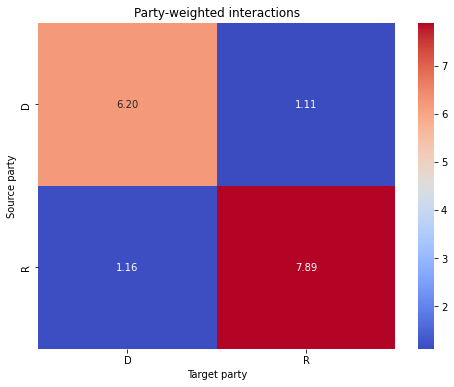

In [21]:
data = attributes_df.set_index('congress_member').drop("age",axis=1)

# Dictionnary that link party to congress member
party_dict = {username: data.loc[username, 'party'] for username in usernameList}
parties = attributes_df['party'].unique()

# Initialisation of the weighted matrix
weighted_interaction_matrix = pd.DataFrame(0, index=parties, columns=parties)

# Compute the population per party for ponderation
party_counts = attributes_df['party'].value_counts()

for i, out_edges in enumerate(outList):
    source_party = party_dict[usernameList[i]]
    
    for j, target in enumerate(out_edges):
        target_party = party_dict[usernameList[target]]
        
        weight = outWeight[i][j]
        
        # Factor to adjust the weight
        adjustment_factor = 1 / (party_counts[source_party] + party_counts[target_party])
        adjusted_weight = weight * adjustment_factor * 100
        
        weighted_interaction_matrix.loc[source_party, target_party] += adjusted_weight
        
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_interaction_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Party-weighted interactions")
plt.xlabel("Target party")
plt.ylabel("Source party")
plt.show()

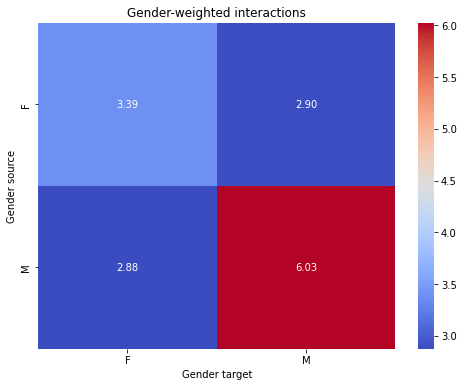

In [22]:
# Dictionnary that link sex to congress member
sex_dict = {username: data.loc[username, 'sex'] for username in usernameList}
sexes = attributes_df['sex'].unique()

# Initialisation of the weighted matrix
weighted_interaction_matrix = pd.DataFrame(0, index=sexes, columns=sexes)

# Compute the population per party for ponderation
sex_counts = attributes_df['sex'].value_counts()

for i, out_edges in enumerate(outList):
    source_sex = sex_dict[usernameList[i]]
    
    for j, target in enumerate(out_edges):
        target_sex = sex_dict[usernameList[target]]
        
        weight = outWeight[i][j]
        
        # Factor to adjust the weight
        adjustment_factor = 1 / (sex_counts[source_sex] + sex_counts[target_sex])
        adjusted_weight = weight * adjustment_factor * 100

        weighted_interaction_matrix.loc[source_sex, target_sex] += adjusted_weight
        
# Créer un graphique de la matrice d'interactions pondérée entre partis
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_interaction_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Gender-weighted interactions")
plt.xlabel("Gender target")
plt.ylabel("Gender source")
plt.show()

### Blau index

In [24]:
def blau_index(df, col):
    return 1-((df[col].value_counts()/df[col].count())**2).sum()

def IQV(df, col):
    nb_categories = len(df[col].unique())
    return blau_index(attributes_df, column) * (nb_categories/(nb_categories-1))

features = ['party', 'chamber', 'sex', 'age_recode']

# Calculer l'indice de Blau pour chaque colonne
for column in features:
    index = blau_index(attributes_df, column)
    print(f"Blau index for '{column}': {index:.4f}")

print("\n")

for column in features:
    index = IQV(attributes_df, column)
    print(f"Normalised Blau index for '{column}': {index:.4f}")

Blau index for 'party': 0.4981
Blau index for 'chamber': 0.3123
Blau index for 'sex': 0.4175
Blau index for 'age_recode': 0.7711


Normalised Blau index for 'party': 0.9963
Normalised Blau index for 'chamber': 0.6247
Normalised Blau index for 'sex': 0.8349
Normalised Blau index for 'age_recode': 0.9253
